In [14]:
import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [15]:
# Baixar dataset
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path baixado:", path)

# Detectar subpasta que contém as classes
for d in os.listdir(path):
    candidate_path = os.path.join(path, d)
    if os.path.isdir(candidate_path) and len(os.listdir(candidate_path)) > 0:
        dataset_path = candidate_path
        break

print("dataset_path detectado:", dataset_path)
print("Classes encontradas:", os.listdir(dataset_path))

Path baixado: C:\Users\luisf\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8
dataset_path detectado: C:\Users\luisf\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8\garbage-dataset
Classes encontradas: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [16]:
# Função para extrair features (resize e flatten)
def extract_features(img_path, img_size):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    return img.flatten()

In [17]:
results = []

# Loop para diferentes tamanhos de imagem e modelos
for img_size in [64, 128, 256]:
    X, y = [], []

    # Carregar dados reais (limitar para rodar mais rápido)
    for label in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, label)
        if os.path.isdir(class_dir):
            # A quantidade de imagens a serem analisadas de cada classe foi reduzida para que o código consiga rodar o exemplo mais facilmente
            for img_file in os.listdir(class_dir)[:50]:
                img_path = os.path.join(class_dir, img_file)
                features = extract_features(img_path, img_size)
                X.append(features)
                y.append(label)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # KNN
    for k in [3,5,7]:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True, zero_division=0)
        results.append({
            'model': 'KNN', 'img_size': img_size, 'param': f'n_neighbors={k}',
            'param_value': k,
            'accuracy': report['accuracy'],
            'f1_score': report['macro avg']['f1-score']
        })

    # Random Forest
    for n in [50,100,150]:
        clf = RandomForestClassifier(n_estimators=n, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True, zero_division=0)
        results.append({
            'model': 'Random Forest', 'img_size': img_size, 'param': f'n_estimators={n}',
            'param_value': n,
            'accuracy': report['accuracy'],
            'f1_score': report['macro avg']['f1-score']
        })

    # SVM
    for kernel in ['linear','rbf','poly']:
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True, zero_division=0)
        results.append({
            'model': 'SVM', 'img_size': img_size, 'param': f'kernel={kernel}',
            'param_value': kernel,
            'accuracy': report['accuracy'],
            'f1_score': report['macro avg']['f1-score']
        })

    # Decision Tree
    for depth in [5,10,20]:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True, zero_division=0)
        results.append({
            'model': 'Decision Tree', 'img_size': img_size, 'param': f'max_depth={depth}',
            'param_value': depth,
            'accuracy': report['accuracy'],
            'f1_score': report['macro avg']['f1-score']
        })

In [18]:
# DataFrame com resultados
df = pd.DataFrame(results)
print(df)

            model  img_size             param param_value  accuracy  f1_score
0             KNN        64     n_neighbors=3           3      0.24  0.211327
1             KNN        64     n_neighbors=5           5      0.28  0.238471
2             KNN        64     n_neighbors=7           7      0.29  0.259781
3   Random Forest        64   n_estimators=50          50      0.28  0.276604
4   Random Forest        64  n_estimators=100         100      0.27  0.258179
5   Random Forest        64  n_estimators=150         150      0.29  0.280768
6             SVM        64     kernel=linear      linear      0.23  0.222169
7             SVM        64        kernel=rbf         rbf      0.31  0.293186
8             SVM        64       kernel=poly        poly      0.31  0.299750
9   Decision Tree        64       max_depth=5           5      0.13  0.115729
10  Decision Tree        64      max_depth=10          10      0.17  0.161402
11  Decision Tree        64      max_depth=20          20      0

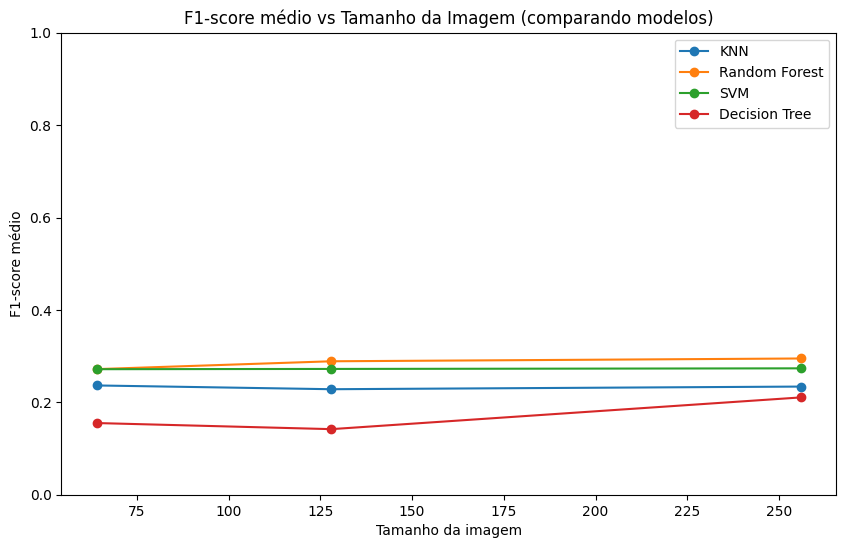

In [19]:
# Gráfico: f1-score médio vs tamanho da imagem
plt.figure(figsize=(10,6))
for model in df['model'].unique():
    subset = df[df['model']==model]
    avg_f1 = subset.groupby('img_size')['f1_score'].mean()
    plt.plot(avg_f1.index, avg_f1.values, marker='o', label=model)

plt.title('F1-score médio vs Tamanho da Imagem (comparando modelos)')
plt.xlabel('Tamanho da imagem')
plt.ylabel('F1-score médio')
plt.ylim(0,1)
plt.legend()
plt.show()

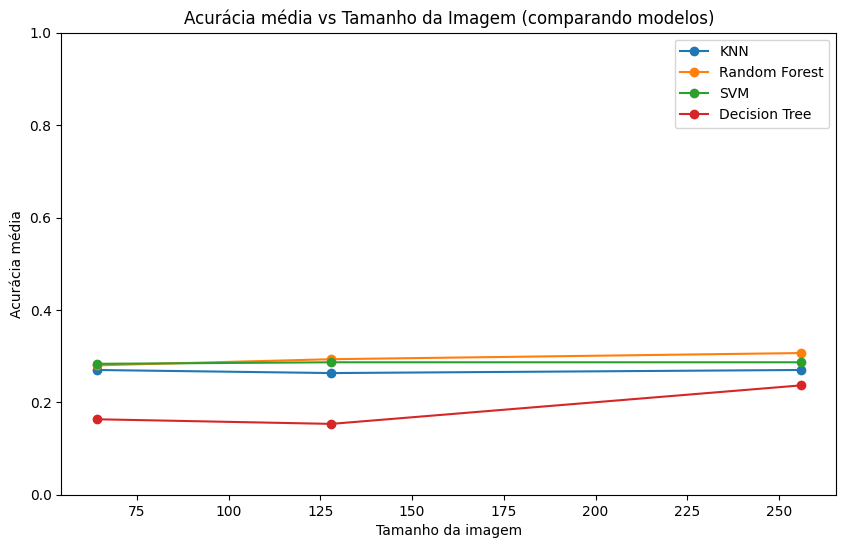

In [20]:
# Gráfico: acurácia média vs tamanho da imagem
plt.figure(figsize=(10,6))
for model in df['model'].unique():
    subset = df[df['model']==model]
    avg_acc = subset.groupby('img_size')['accuracy'].mean()
    plt.plot(avg_acc.index, avg_acc.values, marker='o', label=model)

plt.title('Acurácia média vs Tamanho da Imagem (comparando modelos)')
plt.xlabel('Tamanho da imagem')
plt.ylabel('Acurácia média')
plt.ylim(0,1)
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

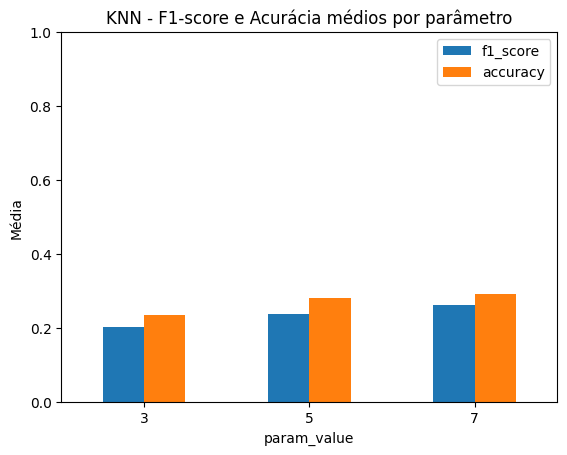

<Figure size 1000x500 with 0 Axes>

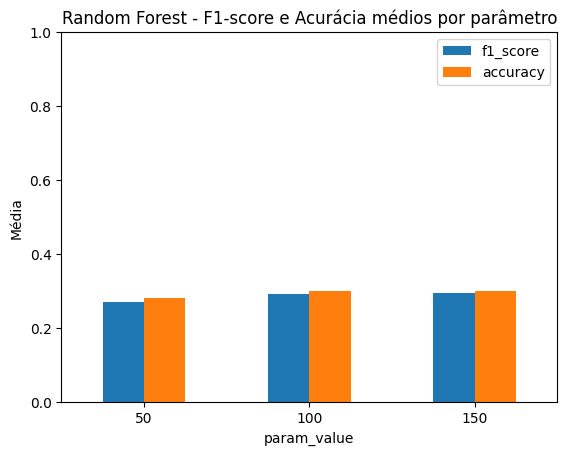

<Figure size 1000x500 with 0 Axes>

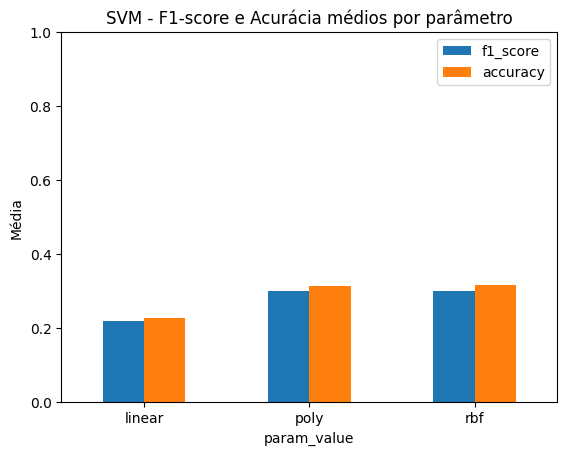

<Figure size 1000x500 with 0 Axes>

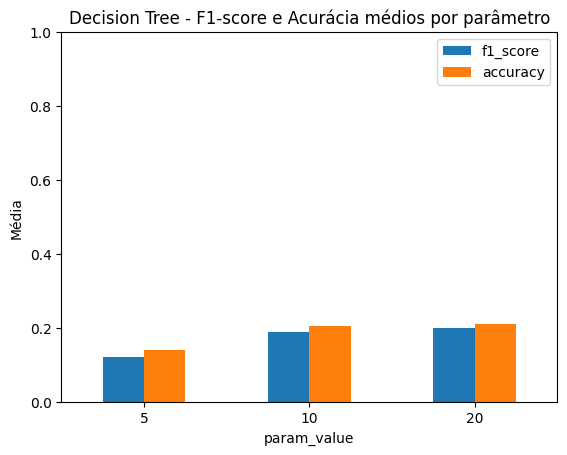

In [22]:
# Gráfico: desempenho por parâmetro (F1-score e acurácia) para cada modelo
for model in df['model'].unique():
    subset = df[df['model']==model]

    plt.figure(figsize=(10,5))
    if subset['param_value'].dtype == object:
        avg = subset.groupby('param_value')[['f1_score','accuracy']].mean()
        avg.plot(kind='bar', ylim=(0,1))
        plt.title(f'{model} - F1-score e Acurácia médios por parâmetro')
        plt.ylabel('Média')
        plt.xticks(rotation=0)
        plt.show()
    else:
        avg = subset.groupby('param_value')[['f1_score','accuracy']].mean()
        plt.plot(avg.index, avg['f1_score'], marker='o', label='F1-score')
        plt.plot(avg.index, avg['accuracy'], marker='s', label='Acurácia')
        plt.title(f'{model} - F1-score e Acurácia médios por parâmetro')
        plt.xlabel('Valor do parâmetro')
        plt.ylabel('Média')
        plt.ylim(0,1)
        plt.legend()
        plt.show()